In [29]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler  # Add this line to import StandardScaler
from xgboost import XGBRegressor
import pickle
import matplotlib.pyplot as plt
from mapie.regression import MapieRegressor
from mapie.metrics import regression_coverage_score

# Step 1: Load Dataset
df = pd.read_csv("Traffic_Volume.csv")
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,10/2/12 9:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,10/2/12 10:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,10/2/12 11:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,10/2/12 12:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,10/2/12 13:00,4918


In [30]:
# Step 2: Convert 'date_time' to datetime and extract useful features
df['date_time'] = pd.to_datetime(df['date_time'])
df['hour'] = df['date_time'].dt.hour
df['day'] = df['date_time'].dt.day
df['month'] = df['date_time'].dt.month
df['weekday'] = df['date_time'].dt.weekday

# Step 3: Handle the 'holiday' column by encoding it as binary
df['holiday'] = df['holiday'].apply(lambda x: 0 if x == 'None' else 1)

# Step 4: One-hot encode 'weather_main' column
weather_encoded = pd.get_dummies(df['weather_main'], prefix='weather')
data = pd.concat([df, weather_encoded], axis=1)

# Step 5: Drop unnecessary columns
data.drop(['weather_main', 'date_time'], axis=1, inplace=True)

C:\Users\17147\AppData\Local\Temp\ipykernel_24384\3088130364.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date_time'] = pd.to_datetime(df['date_time'])


In [31]:
# Step 3: Data Preprocessing
# Got a Memory Error because the training data is too large, reduced the training data size
data = data.head(1000)
# Define features (X) and target (y)
X = data.drop(columns=["traffic_volume"])
y = data["traffic_volume"]

In [32]:
# Step 4: Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
# Step 5: Train XGBoost Model
import xgboost
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [34]:
# Step 6: Wrap with MAPIE for Prediction Intervals
# Initialize MAPIE regressor
mapie = MapieRegressor(estimator=xgb_model, random_state=42)

# Fit MAPIE regressor on the training data
import time
start = time.time()  
mapie.fit(X_train, y_train)  # Use the appropriate training data (X_train, y_train)
stop = time.time()             

# Output the training time
print(f"Training time: {stop - start}s")

Training time: 1.1314277648925781s


In [35]:
from sklearn.metrics import mean_squared_error, r2_score
# Step 7: Evaluate Model
y_pred = mapie.predict(X_test, alpha=0.05)
y_pred_mean = y_pred[0]
y_pred_low, y_pred_high = y_pred[1][:, 0], y_pred[1][:, 1]

rmse = mean_squared_error(y_test, y_pred_mean, squared=False)
r2 = r2_score(y_test, y_pred_mean)
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

RMSE: 213.64692629283505
R²: 0.9893020391464233


C:\Users\17147\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


C:\Users\17147\AppData\Local\Temp\ipykernel_24384\3836105198.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x="Importance", y="Feature", palette="viridis")


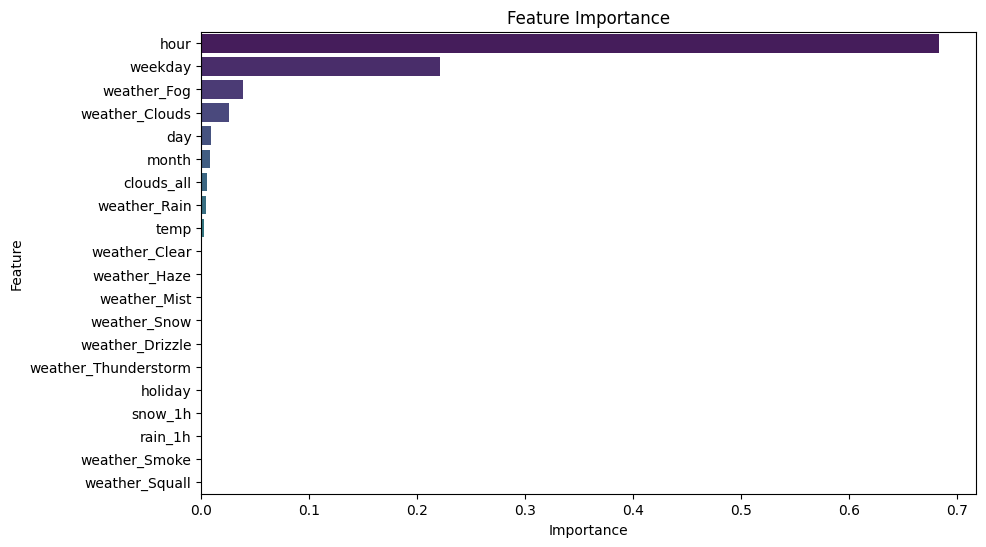

In [36]:
# Step 8: Visualizations
# Feature Importance
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Plotting the feature importance
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importance")
plt.show()

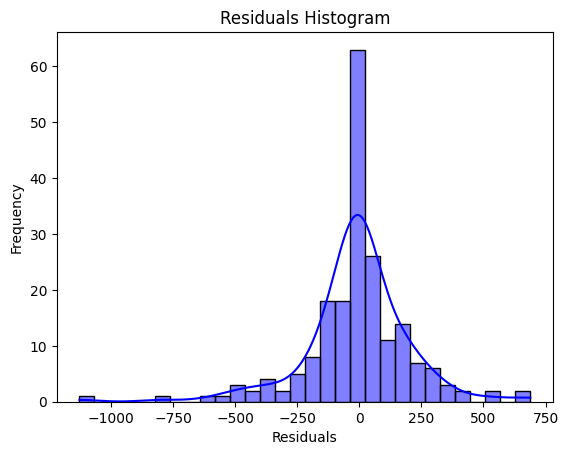

In [37]:
# Residuals Histogram
residuals = y_test - y_pred_mean
sns.histplot(residuals, kde=True, bins=30, color="blue")
plt.title("Residuals Histogram")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

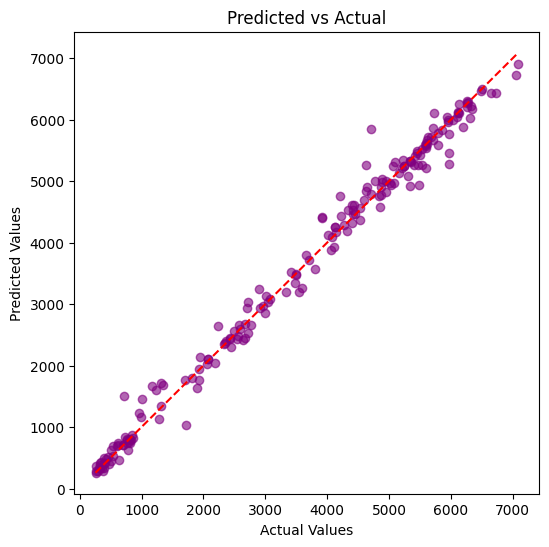

In [38]:
# Scatter Plot of Predicted vs Actual
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_mean, alpha=0.6, color="purple")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.title("Predicted vs Actual")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

In [39]:
# Calculate Coverage
# Use mapie.predict() to get predicted values and intervals for the top 200 entries to avoid MemoryError

alpha = 0.1  # For 90% confidence level
test_X = X_test.head(200)  # Selecting the top 200 entries for memory efficiency
y_test_pred, y_test_pis = mapie.predict(test_X, alpha=alpha)

# Extract lower and upper bounds and ensure they are 1-dimensional
y_test_low = y_test_pis[:, 0].ravel()  # Flatten to (200,)
y_test_high = y_test_pis[:, 1].ravel()  # Flatten to (200,)

# Ensure y_test is sliced to match test_X (if it is a Pandas Series or array)
y_test_subset = y_test.head(200)  # Match the subset size

# Calculate coverage
coverage = ((y_test_subset >= y_test_low) & (y_test_subset <= y_test_high)).mean()
coverage_percentage = coverage * 100

print(f"Coverage: {coverage_percentage:.2f}%")

Coverage: 93.00%


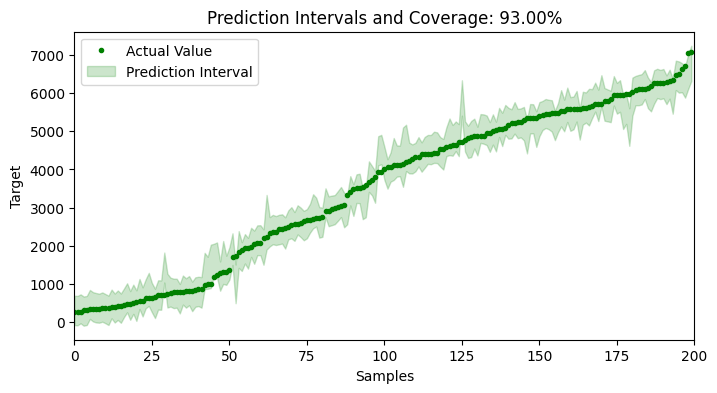

In [40]:
# Prepare data for visualization
predictions = pd.DataFrame({
    'Actual Value': y_test_subset.values,  # Ensure it's aligned with y_test_low/high
    'Predicted Value': y_test_pred,
    'Lower Value': y_test_low,
    'Upper Value': y_test_high
}).sort_values(by=['Actual Value']).reset_index(drop=True)

# Plot actual values and prediction intervals
plt.figure(figsize=(8, 4))
plt.plot(predictions["Actual Value"], 'go', markersize=3, label="Actual Value")
plt.fill_between(np.arange(len(predictions)),
                 predictions["Lower Value"],
                 predictions["Upper Value"],
                 alpha=0.2, color="green", label="Prediction Interval")
plt.xlim([0, len(predictions)])
plt.xlabel("Samples")
plt.ylabel("Target")
plt.title(f"Prediction Intervals and Coverage: {coverage_percentage:.2f}%")
plt.legend(loc="upper left")
plt.show()

In [41]:
# Step 9: Save Models and Preprocessing Objects
with open("xgb_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)

with open("mapie_model.pkl", "wb") as f:
    pickle.dump(mapie, f)

# Save processed data structure (if applicable)
X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)